# Model PreTraining

<b>Purpose: </b> Through this script, we will provide the RLHF model a starting point of knowledge on the game via training on annotated gamplay

In [3]:
import os
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
import mlflow
import mlflow.pytorch
import importlib_metadata
from google.cloud import storage
from dotenv import load_dotenv
from io import BytesIO

print("Packages imported!")

# Set the device
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Device: {device}")

# Load environment variables from .env file
load_dotenv()
gcs_credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize GCS Client
client = storage.Client()
print(f"GCS Client Initialized: {client}")


Packages imported!
Device: cpu
GCS Client Initialized: <google.cloud.storage.client.Client object at 0x103b9a590>


In [4]:
# Action mapping from strings to integers
ACTION_MAPPING = {
    "a": 0,
    "b": 1,
    "x": 2,
    "y": 3,
    "up": 4,
    "down": 5,
    "left": 6,
    "right": 7,
    "none": 8
}

### Creating the Data Loader

The dataloader is abnormal in the sense that each data point is actually a sequence of several. <br>
This is done to enable memory, vital for a storyline game like this.

In [5]:
import torch
from torch.utils.data import Dataset
from google.cloud import storage
import json
from PIL import Image
from io import BytesIO

class PokemonDatasetGCS(Dataset):
    def __init__(self, bucket_name, states_prefix, actions_prefix, seq_length, augmentation=None, transform=None, annotations_prefix=None):
        """
        Args:
            bucket_name (str): Name of the GCS bucket.
            states_prefix (str): Prefix for states (images) in GCS.
            actions_prefix (str): Prefix for actions (JSONs) in GCS.
            seq_length (int): Desired sequence length.
            augmentation (callable, optional): Optional image augmentation to apply.
            transform (callable, optional): Optional image transform to apply.
            annotations_prefix (str, optional): Prefix for annotations (JSONs) in GCS.
        """
        self.bucket = storage.Client().bucket(bucket_name)   # Initialize GCS bucket
        self.states_prefix = states_prefix                   # Prefix for states (images) in GCS
        self.actions_prefix = actions_prefix                 # Prefix for actions (JSONs) in GCS
        self.annotations_prefix = annotations_prefix         # Prefix for annotations (JSONs) in GCS
        self.transform = transform                           # Any image transformations
        self.augmentation = augmentation                     # Any image augmentations
        self.seq_length = seq_length                          # Desired sequence length

        # Fetch the list of blobs (files) in each folder
        self.states = sorted([blob.name for blob in self.bucket.list_blobs(prefix=states_prefix) if blob.name.endswith('.jpg')])
        self.actions = sorted([blob.name for blob in self.bucket.list_blobs(prefix=actions_prefix) if blob.name.endswith('.json')])

        # Fetch the list of annotation files if annotations_prefix is provided
        if annotations_prefix is not None:
            self.annotations = sorted([blob.name for blob in self.bucket.list_blobs(prefix=annotations_prefix) if blob.name.endswith('.json')])
        else:
            self.annotations = None

    def __len__(self):
        return len(self.states) - self.seq_length

    def __getitem__(self, idx):
        state_seq = []
        action_seq = []
        annotation_seq = []

        # Loop to obtain seq_length states, actions, and optionally annotations
        for i in range(self.seq_length):
            # Load image from GCS
            try:
                state_blob = self.bucket.blob(self.states[idx + i])
                image_data = state_blob.download_as_bytes()  # Download the image as bytes
                image = Image.open(BytesIO(image_data)).convert('RGB')  # Ensure image is in RGB format

                # Apply augmentation and transformation
                if self.augmentation:
                    image = self.augmentation(image)
                
                if self.transform:
                    image = self.transform(image)

                state_seq.append(image)

            except Exception as e:
                print(f"Error downloading image {self.states[idx + i]}: {e}")
                return None
            
            # Load action JSON from GCS
            try:
                action_blob = self.bucket.blob(self.actions[idx + i])
                action_data = json.loads(action_blob.download_as_text())
                action = action_data.get('action', None)

                if action is None:
                    print(f"Warning: 'action' key missing in {action_blob.name}")
                    return None
                else:
                    action_seq.append(ACTION_MAPPING[action])

            except (json.JSONDecodeError, Exception) as e:
                print(f"Error downloading or decoding action {self.actions[idx + i]}: {e}")
                return None

            # Load annotation JSON from GCS if annotations are available
            if self.annotations is not None:
                try:
                    annotation_blob = self.bucket.blob(self.annotations[idx + i])
                    annotation_data = json.loads(annotation_blob.download_as_text())
                    annotation_tensor = torch.tensor(annotation_data, dtype=torch.float32)  # Convert annotations to tensor
                    annotation_seq.append(annotation_tensor)

                except (json.JSONDecodeError, Exception) as e:
                    print(f"Error downloading or decoding annotation {self.annotations[idx + i]}: {e}")
                    return None

        # Convert state sequences to tensor
        state_seq_tensor = torch.stack(state_seq)

        # Convert action sequences to tensor
        action_seq_tensor = torch.tensor(action_seq, dtype=torch.long)

        # Convert annotation sequences to tensor if annotations are used
        if self.annotations is not None and annotation_seq:
            annotation_seq_tensor = torch.stack(annotation_seq)
            return (state_seq_tensor, action_seq_tensor, annotation_seq_tensor)
        else:
            return (state_seq_tensor, action_seq_tensor)


In [6]:
class PokemonDataset(Dataset):
    def __init__(self, states_dir, actions_dir, seq_length, transform=None):
        self.states_dir = states_dir                            # Reading in the states directory
        self.actions_dir = actions_dir                          # Reading in the actions directory
        self.transform = transform                              # Any image transformations 
        
        # Filter files to only include valid images
        self.states = sorted([f for f in os.listdir(states_dir) if f.endswith(('.jpg', '.png'))])
        self.actions = sorted([f for f in os.listdir(actions_dir) if f.endswith('.json')])

        self.seq_length = seq_length                            # Reading in the desired seq length

    def __len__(self):
        return len(self.states) - self.seq_length               # Returns len of dataloader
    
    def __getitem__(self, idx):
        state_seq = []
        action_seq = []

        # Obtaining seq_length images, actions, and annotations
        for i in range(self.seq_length):

            # Retrieve image
            img_name = os.path.join(self.states_dir, self.states[idx + i])
            image = Image.open(img_name).convert('RGB')  # Ensure image is in RGB format
            if self.transform:
                image = self.transform(image) # Transform image
            state_seq.append(image)

            # Retrieve action
            action_name = os.path.join(self.actions_dir, self.actions[idx + i])
            ## Check if the JSON file is empty or corrupted
            try:
                with open(action_name, 'r') as f:
                    if os.stat(action_name).st_size == 0:
                        print(f"Warning: {action_name} is empty. Skipping this file.")
                        action_seq.append(None)  # Skip this entry
                        continue

                    action_data = json.load(f)
                    action = action_data.get('action', None)

                    if action is None:
                        print(f"Warning: 'action' key missing in {action_name}")
                        action_seq.append(None)  # Skip this entry
                    else:
                        action_seq.append(ACTION_MAPPING[action])
            except json.JSONDecodeError as e:
                print(f"Warning: Failed to decode JSON in {action_name}: {e}")
                action_seq.append(None)  # Skip this entry

        # Convert state sequences to tensor
        state_seq_tensor = torch.stack(state_seq)

        # Convert action sequences to tensor
        action_seq_tensor = torch.tensor(action_seq, dtype=torch.long)

        
        return state_seq_tensor, action_seq_tensor

Initialise Dataloader

## Model Training

### Hyperparameter Tuning

##### Initialization of variables and tuning function declaration

In [7]:
import itertools
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
from models.PokemonModelLSTM import PokemonModelLSTM

# Define the ranges of hyperparameters for the grid search
param_grid = {
    'num_layers': [2, 3, 5],             # Test different numbers of LSTM layers
    'hidden_size': [256, 512, 1024],   # Larger hidden sizes based on observation
    'learning_rate': [0.0005, 0.001, 0.0015]   # Fine-tuned learning rates
}

# Functions
## Dataloader Filter/None-Check
def filter_dataloader(dataloader):
    """Filter out None batches and return only valid data."""
    valid_batches = []
    for batch in dataloader:
        if batch is not None:
            valid_batches.append(batch)
    return valid_batches

## Parameter Tuning Main Fn
def param_tuning(dataloader, param_grid = param_grid, num_epochs = 10, cropped = [True, False], plot = [True, False]):
    """The following fn takes in the parameter grid to test and num_epochs,
        It then trains the model several times, each time on a slightly different set of hyperparameters.
         
        Input:
        - param_grid: dictionary with hyperparameters and their values
        - num_epochs: int for number of loops for training
        - dataset: the dataset containing the state/action pairs
        
        Returns:
        - best_model: the model that provided the best results
        - results: the loss results for each epoch of each training combination"""

    # Create all combinations of the parameters
    param_combinations = list(itertools.product(
        param_grid['num_layers'], 
        param_grid['hidden_size'], 
        param_grid['learning_rate'],
        param_grid['conv1_dim'],
        param_grid['conv2_dim'],
    ))
    
    # Define allowed actions for Phase 1
    allowed_actions = [4, 7]  # Indices for "up" and "right"

    # Loop through each combination of hyperparameters
    best_model = None
    best_loss = float('inf')  # Initialize the best loss as infinity
    results = []  # To store the results of each parameter set

    for i, (num_layers, hidden_size, learning_rate, conv1_dim, conv2_dim) in enumerate(param_combinations):
        print(f"Training model {i+1}/{len(param_combinations)} with num_layers={num_layers}, hidden_size={hidden_size}, learning_rate={learning_rate}, conv1_dim ={conv1_dim}, conv2_dim = {conv2_dim}")
        if cropped == True:
            input_size = conv2_dim * 80 *160
        elif cropped == False:
            input_size = conv2_dim * 160 * 160

        # Setting Hyperparameters
        num_actions = 9             # (Total Number of Actions: [A, B, X, Y, Up, Down, Left, Right, None]) (Excluding Start, Select, L, R to reduce model complexity)
        device = 'cpu'
        
        # Initialize the model with the current hyperparameters
        model = PokemonModelLSTM(input_size = input_size, 
                                hidden_size= hidden_size,
                                num_layers= num_layers,
                                num_actions=num_actions,
                                conv1_dim=conv1_dim,
                                conv2_dim= conv2_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        epoch_losses = []

        
        # Train the model (here you could add your training loop)
        model.train()
        total_loss = 0  # To accumulate the average loss across all epochs

        for epoch in range(1, num_epochs+1):
            epoch_loss = 0  # Reset loss for the new epoch
            for batch in dataloader:
                if batch is None:
                    continue

                # Unpack the batch, checking if annotations are included
                if len(batch) == 3:
                    state_seq, action_seq, annotation_seq = batch
                    state_seq, action_seq, annotation_seq = state_seq.to(device), action_seq.to(device), annotation_seq.to(device)
                    output = model(state_seq, annotations=annotation_seq)  # Pass annotations if available
                else:
                    state_seq, action_seq = batch
                    state_seq, action_seq = state_seq.to(device), action_seq.to(device)
                    output = model(state_seq)  # No annotations provided

                optimizer.zero_grad()
                output = model(state_seq)
                action_seq = action_seq[:, -1]
                
                loss = criterion(output, action_seq)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()  # Accumulate loss for this epoch


            # Compute the average loss for the epoch
            avg_epoch_loss = epoch_loss / len(dataloader)
            epoch_losses.append(avg_epoch_loss)
            print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {avg_epoch_loss}")

            total_loss += avg_epoch_loss  

            # Append results after all epochs are completed
            results.append({
                'num_layers': num_layers,
                'hidden_size': hidden_size,
                'learning_rate': learning_rate,
                'epoch':epoch,
                'epoch_loss': avg_epoch_loss
            })

        overall_avg_loss = total_loss / num_epochs
        
        if overall_avg_loss < best_loss:
            best_loss = overall_avg_loss
            best_model = model

        if plot:
            plt.figure(figsize=(6, 4))
            plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Loss', marker='o')
            plt.title(f"layers={num_layers}, hidden={hidden_size}, lr={learning_rate}, conv1={conv1_dim}, conv2={conv2_dim}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.xticks(range(1, num_epochs + 1))
            plt.yticks(np.arange(0.5,2.5,0.1))
            
            # Add labels for each point
            for x, y in enumerate(epoch_losses, start=1):
                plt.text(x, y, f"{y:.2f}", ha='right', va='bottom', fontsize=8)
            
            plt.legend()
            plt.show()

        print(f"Model {i+1} average loss across all epochs: {overall_avg_loss}")


    # Print the best hyperparameters and their results
    print(f"Best model found with num_layers={best_model.num_layers}, hidden_size={best_model.hidden_size}, learning_rate={learning_rate} and avg_loss={best_loss}")

    return best_model, results



#### Ensuring that the images for resizes and resized + crop are being processed properly

GCS Client Initialized: <google.cloud.storage.client.Client object at 0x1594ab640>


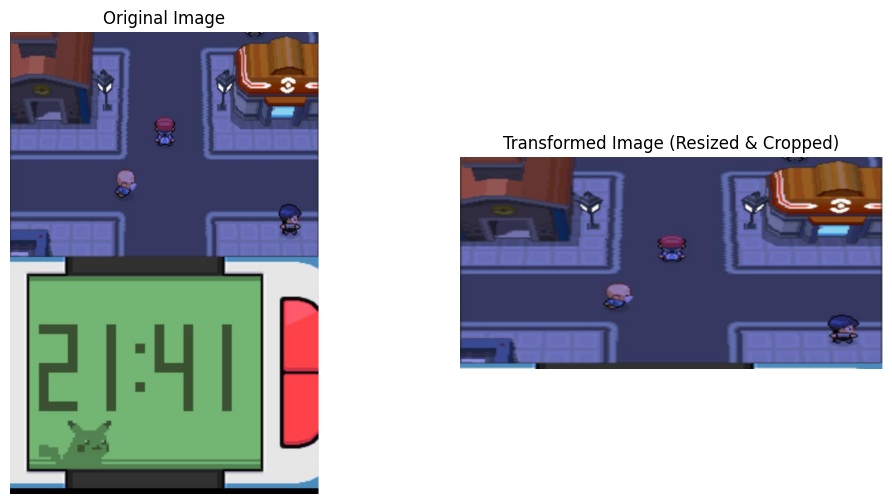

In [8]:
from google.cloud import storage
from dotenv import load_dotenv
from io import BytesIO
import os
from torchvision import transforms
from PIL import Image
from RLHF_Scripts.modular_scripts.rlhf_utils import ACTION_MAP_DIALOGUE, REVERSED_ACTION_MAPPING
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

# Load environment variables from .env file
load_dotenv()
gcs_credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize GCS Client
client = storage.Client()
print(f"GCS Client Initialized: {client}")

# Define the GCS bucket and file path
bucket_name = 'pokemonplatinumai-annotationimages'
file_path = 'phase-1/images/2024-09-01_21-41-17_png.rf.8afcea2c3ddb01cfa1caa95e8777b066.jpg'

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((640,640)),  # Resize image
    transforms.Lambda(lambda img: F.crop(img, top=0, left=0, height=320, width=640)),  # Crop bottom half
    transforms.ToTensor(),  # Convert image to tensor
])

# Initialize GCS client and get the image file
client = storage.Client()
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(file_path)

# Download the image as a byte stream and open it
image_data = blob.download_as_bytes()
original_image = Image.open(BytesIO(image_data))

# Apply the transformations
transformed_image = transform(original_image)

# Plot the original and transformed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Convert transformed tensor to a PIL image for visualization
transformed_pil_image = transforms.ToPILImage()(transformed_image)
axes[1].imshow(transformed_pil_image)
axes[1].set_title('Transformed Image (Resized & Cropped)')
axes[1].axis('off')

plt.show()


#### Option 1: Resized and Cropped images

DataLoader loaded!
Batch loading complete (or stopped due to an error).
Training Beginning...

Training model 1/4 with num_layers=2, hidden_size=64, learning_rate=0.0015, conv1_dim =64, conv2_dim = 128
Epoch [1/15], Average Loss: 2.180639704068502
Epoch [2/15], Average Loss: 1.9527474244435628
Epoch [3/15], Average Loss: 1.7758437196413677
Epoch [4/15], Average Loss: 1.5952749252319336
Epoch [5/15], Average Loss: 1.452136516571045
Epoch [6/15], Average Loss: 1.3663849035898845
Epoch [7/15], Average Loss: 1.3226284384727478
Epoch [8/15], Average Loss: 1.2993290921052296
Epoch [9/15], Average Loss: 1.2852872808774312
Epoch [10/15], Average Loss: 1.276442547639211
Epoch [11/15], Average Loss: 1.2709254920482635
Epoch [12/15], Average Loss: 1.2674134870370228
Epoch [13/15], Average Loss: 1.2649797399838765
Epoch [14/15], Average Loss: 1.263091007868449
Epoch [15/15], Average Loss: 1.2614999413490295


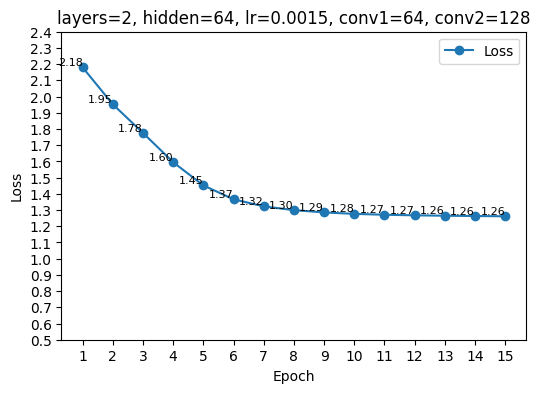

Model 1 average loss across all epochs: 1.4556416147285036
Training model 2/4 with num_layers=2, hidden_size=64, learning_rate=0.0015, conv1_dim =64, conv2_dim = 256


: 

In [10]:
# Image transformations and augmentations
## Chosen transformation (Always occur)
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.Lambda(lambda img: F.crop(img, top=0, left=0, height=320, width=640)),  # Crop bottom half
    transforms.ToTensor()
])
## Chosen augmentatons (Randomly occur)
augmentation = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Random colour augmentation
    transforms.RandomRotation(degrees=30),                # Random rotation
])


# Initialize dataloader
## For phase 1, it will only really need the last few frames
seq_length = 3
## Set the GCS bucket and folder prefixes
bucket_name = 'pokemonplatinumai-annotationimages'
states_prefix = 'phase-1/images/'
actions_prefix = 'phase-1/actions/'
annotations_prefix = 'phase-1/labels'
## Create the dataset
cropped_dataset = PokemonDatasetGCS(
    bucket_name=bucket_name,
    states_prefix=states_prefix,
    actions_prefix=actions_prefix,
    annotations_prefix = None,
    seq_length=seq_length,
    transform=transform,
    augmentation = augmentation
)

cropped_dataloader = DataLoader(cropped_dataset, batch_size=4, shuffle=False)

print("DataLoader loaded!")

# Define the ranges of hyperparameters for the grid search
param_grid = {
    'num_layers': [2],                          # Test different numbers of LSTM layers
    'hidden_size': [64],                       # Larger hidden sizes based on observation
    'learning_rate': [0.0015],                  # Fine-tuned learning rates
    'conv1_dim':[64,128],
    'conv2_dim':[128,256],
}

for batch in cropped_dataloader:
    try:
        # If batch is None or there is an issue, this will catch it
        if batch is None:
            raise ValueError("Encountered NoneType batch")

    except Exception as e:
        print(f"Error processing batch: {e}")
        break  # Break out of the loop if an error occurs

print("Batch loading complete (or stopped due to an error).")

print("Training Beginning...\n")

best_model, cropped_results = param_tuning(param_grid= param_grid,
                                           num_epochs=15,
                                           dataloader=cropped_dataloader,
                                           cropped = True,
                                           plot = True)

#### Option 2: No Crop   

In [27]:
# Chosen transformation
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

# Chosen augmentatons
augmentation = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Random colour augmentation
    transforms.RandomRotation(degrees=30),                # Random rotation
])

seq_length = 5
# Set the GCS bucket and folder prefixes
bucket_name = 'pokemonplatinumai-annotationimages'
states_prefix = 'phase-1/images/'
actions_prefix = 'phase-1/actions/'

dataset = PokemonDatasetGCS(
    bucket_name=bucket_name,
    states_prefix=states_prefix,
    actions_prefix=actions_prefix,
    seq_length=seq_length,
    transform=transform,
    augmentation = augmentation
)
cropped_dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

print("DataLoader loaded!")

best_model, cropped_results = param_tuning(dataloader=cropped_dataloader)

DataLoader loaded!


KeyError: 'conv1_dim'

Initialise the model

In [ ]:
import itertools
import torch.optim as optim
from models.PokemonModelLSTM import PokemonModelLSTM

# Setting Hyperparameters
num_actions = 9             # (Total Number of Actions: [A, B, X, Y, Up, Down, Left, Right, None]) (Excluding Start, Select, L, R to reduce model complexity)
input_size = 32 * 80 * 160
hidden_size = 128
num_layers = 4
num_epochs = 20
learning_rate = 0.001

# Initialising model
model = PokemonModelLSTM(input_size, hidden_size, num_layers, num_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


### Phase1

In [ ]:
# Training loop
for epoch in range(1,num_epochs+1):
    model.train()
    epoch_loss = 0  # Track loss for the current epoch
    
    for i, batch in enumerate(dataloader):
        # Skip batches that returned None
        if batch is None:
            print(f"Skipping batch {i} due to missing data.")
            continue
        else:
            print(f"Processing epoch {epoch}, batch {i}")
        
        state_seq, action_seq = batch
        state_seq, action_seq = state_seq.to(device), action_seq.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(state_seq)

        # Calculate loss
        action_seq = action_seq[:, -1]  # Get the last action in the sequence for each batch
        loss = criterion(output, action_seq)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for the epoch
        epoch_loss += loss.item()
    
    # Log loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    
    print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {avg_loss}")

    
    # Save the model, optimizer state, and other information after each epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }
    while True:
        try:
            model_path = f"models/phase1/pokemon_model_lstm_epoch_{epoch}.pth"
            torch.save(checkpoint, model_path)
            break
        except Exception as e:
            print(f"Error saving model: {e}")
            retry = ''
            while retry not in ['yes', 'no']:
                retry = input(f"Try again? (yes/no): ")
            if retry == 'no':
                break

# Save final model with all relevant states
final_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    }

final_model_path = "models/pokemon_model_lstm_final.pth"
torch.save(final_checkpoint, final_model_path)

print("Model and metrics logged with MLflow!")

### Testing the model

In [ ]:
from google.cloud import storage
from dotenv import load_dotenv
from io import BytesIO
import os
from torchvision import transforms
from PIL import Image
from RLHF_Scripts.modular_scripts.rlhf_utils import ACTION_MAP_DIALOGUE, REVERSED_ACTION_MAPPING
import matplotlib.pyplot as plt


# Load environment variables from .env file
load_dotenv()
gcs_credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize GCS Client
client = storage.Client()
print(f"GCS Client Initialized: {client}")

# Define the GCS bucket and file path
bucket_name = 'pokemonplatinumai-annotationimages'
file_path = 'phase-1/images/2024-09-01_21-41-17_png.rf.8afcea2c3ddb01cfa1caa95e8777b066.jpg'

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((640,640)),  # Resize image
    transforms.ToTensor(),  # Convert image to tensor
])

# Initialize GCS client and get the image file
client = storage.Client()
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(file_path)

# Download the image as a byte stream and open it
image_data = blob.download_as_bytes()
image = Image.open(BytesIO(image_data))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Apply transformations
image = transform(image)
image = image.unsqueeze(0).unsqueeze(0)  # Add batch dimensions



In [ ]:
import torch
from models.PokemonModelLSTM import PokemonModelLSTM

# Setting Hyperparameters
num_actions = 9 # Number of actions
input_size = 32 * 160 * 160
hidden_size = 128
num_layers = 4
num_epochs = 20
learning_rate = 0.001

# Initialize model
model = PokemonModelLSTM(input_size, hidden_size, num_layers, num_actions)
checkpoint = torch.load("models/phase1/pokemon_model_lstm_epoch_6.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode
print('Model loaded')

# Perform prediction
with torch.no_grad():  # Disable gradient calculations for inference
    action = model(image)  # Pass the image through the model
    predicted_action = torch.argmax(action, dim=1)  # Get the predicted action

action = ACTION_MAP_DIALOGUE[REVERSED_ACTION_MAPPING[predicted_action.item()]]
print(f'Prediction made: {action}')

In [ ]:
# Initialize MLflow experiment
mlflow.set_experiment("PokemonModelLSTM_3")

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("num_actions", num_actions)
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_epochs", num_epochs)
 
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0                       # Track loss for the current epoch
        for i, (state_seq, action_seq) in enumerate(dataloader):
            print(f"Currently processing Epoch {epoch}, batch {i}")
            state_seq, action_seq = state_seq.to(device), action_seq.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(state_seq)

            # Calculate loss
            action_seq = action_seq[:, -1]  # Get the last action in the sequence for each batch
            loss = criterion(output, action_seq)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Accumulate loss for the epoch
            epoch_loss += loss.item()
        
        # Save the model to MLflow
        print(f"Saving model to MLflow")
        mlflow.pytorch.log_model(model, f"model_epoch_{epoch+1}")

        # Log loss for the epoch
        avg_loss = epoch_loss / len(dataloader)
        try: 
            mlflow.log_metric("loss", avg_loss, step=epoch)
        except Exception as e:
            print(f"Error: {e}")
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss}")
        
        # Save the model, optimizer state, and other information after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }
        model_path = f"models/pokemon_model_lstm_epoch_{epoch+1}.pth"
        torch.save(checkpoint, model_path)

    # Save final model with all relevant states
    final_checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
        }
    
    final_model_path = "models/pokemon_model_lstm_final.pth"
    torch.save(final_checkpoint, final_model_path)
    mlflow.pytorch.log_model(model, "final_model")

print("Model and metrics logged with MLflow!")

In [ ]:
# Create a simple test model (or use your existing model)
class TestModel(torch.nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        self.fc = torch.nn.Linear(10, 2)
    
    def forward(self, x):
        return self.fc(x)

# Initialize the model and optimizer
model = TestModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Test the logging step without running the full training loop
def test_mlflow_logging():
    with mlflow.start_run():
        # Create a dummy state dict and loss for testing purposes
        test_checkpoint = {
            'epoch': 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0.5,  # Dummy loss value
        }

        # Save and log the model using MLflow
        model_path = "models/test_model.pth"
        torch.save(test_checkpoint, model_path)

        try:
            # Test logging the model with MLflow
            mlflow.pytorch.log_model(model, "test_model")
            print("MLflow model logging successful.")
        except Exception as e:
            print(f"Error during MLflow logging: {e}")

# Run the test function
test_mlflow_logging()


In [ ]:
def check_versions():
    try:
        # Check torch version using importlib_metadata
        torch_version = importlib_metadata.version("torch")
        print(f"importlib_metadata found torch version: {torch_version}")
    except KeyError as e:
        print(f"Error: Could not find version for 'torch': {e}")
    except Exception as e:
        print(f"Unexpected error occurred: {e}")

    # Also check torch version from the package itself
    print(f"torch.__version__: {torch.__version__}")

    try:
        # Simulate a log model call with MLflow to verify functionality
        model = torch.nn.Linear(2, 2)  # Create a simple dummy model for testing
        mlflow.set_tracking_uri("mlruns")
        mlflow.set_experiment("VerificationExperiment")

        with mlflow.start_run():
            mlflow.pytorch.log_model(
                model, 
                artifact_path="dummy_model",
                pip_requirements=[f"torch=={torch.__version__}", "cloudpickle==2.0.0"]
            )
            print("MLflow logging successful.")
    except Exception as e:
        print(f"MLflow encountered an error: {e}")

# Run the verification
check_versions()
